In [1]:
# loads CSV file generated by PrairieView from running disk 
#
# Derivation of distance:
# B leads A for clockwise shaft rotation, and A leads B for counterclockwise rotation when viewed from the shaft side of the encoder.
# 100 CPR = cycles per revolution = 3.6 deg/cycle
# 0.9 deg/click: (3.6 deg/cycle) * (1 cycle/4 clicks)
# Mouse 6 cm from center of disk, so Circumference = 37.7 cm.  So 37.7 cm / 360 deg = 0.1047 cm/deg
# Finally, 0.1047 cm/deg * 0.9 deg/click = 0.094 cm/click
#
# See http://brianisett.com/2017/06/22/diy-running-disk/
#
# 2019-01-08 Justin
# translate to python 2019-04-29 Ming-Chi


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

velocity_path = '/Volumes/Transfer/18-2258_Awake_Ca-Imaging/m1/VoltageRecording-03262019-0858-001/VoltageRecording-03262019-0858-001_Cycle00001_VoltageRecording_001.csv'

Justin's load velosity code: 

tbl_full = readtable(velocity_path);

tbl = tbl_full(1:1:end,:);

tbl.Input1 = tbl.Input1 > ttl_thresh;

tbl.Input2 = tbl.Input2 > ttl_thresh;

In [2]:
#translation
ttl_thresh = 3  #volts, threshold for TTL detection

df1 = pd.read_csv( velocity_path, skiprows = [0], names = ['Time_ms','Input_1', 'Input_2'])
dfA = df1.loc[:, ['Input_1']]
dfB = df1.loc[:, ['Input_2']]
dfT = df1.loc[:, ['Time_ms']]
dfA = dfA['Input_1']> ttl_thresh
dfB = dfB['Input_2']> ttl_thresh

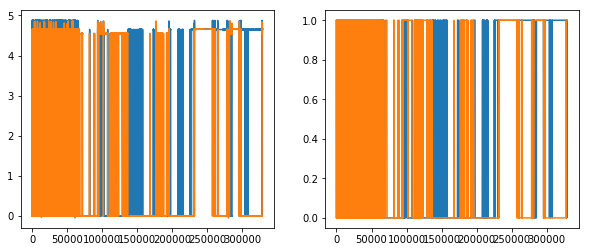

In [3]:
#test
f, ax = plt.subplots(1,2,figsize = (10,4))
ax[0].plot(dfT, df1.Input_1)    
ax[0].plot(dfT, df1.Input_2)
ax[1].plot(df1.Time_ms, dfA)
ax[1].plot(df1.Time_ms, dfB)


# 

clicks = zeros(1,height(tbl));

A_change_inds = find(diff(tbl.Input1)~=0);

B_change_inds = find(diff(tbl.Input2)~=0);

In [4]:
clicks = np.zeros(len(df1))

In [5]:
A_change = np.diff(dfA, axis = 0)
A_change_inds = A_change.nonzero()    #indexing:  A_change_inds[0][0]
B_change = np.diff(dfB, axis = 0)
B_change_inds = B_change.nonzero()

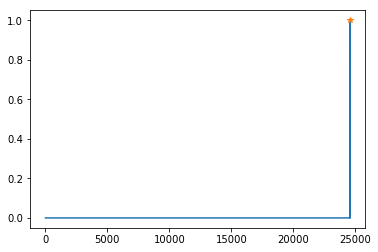

In [6]:
#test
plt.plot(A_change[0:24555])
plt.plot(A_change_inds[0][0], 1,'*')

%Loop over A state (Input 1)

for c = 1:length(A_change_inds)

    A_state =  tbl.Input1(A_change_inds(c)+1); %offset because of diff
        
           B_state =  tbl.Input2(A_change_inds(c)+1); %offset because of diff
    
    switch A_state
    
        case 0
        
            switch B_state
            
                case 0 %clockwise rotation
                
                    clicks(A_change_inds(c)+1) = clicks(A_change_inds(c)+1)+1;
                
                case 1 %counter-clockwise rotation
                
                    clicks(A_change_inds(c)+1) = clicks(A_change_inds(c)+1)-1;
            
            end
        
        case 1
            
            switch B_state
            
                case 0 
                
                    clicks(A_change_inds(c)+1) = clicks(A_change_inds(c)+1)-1;
                
                case 1
                
                    clicks(A_change_inds(c)+1) = clicks(A_change_inds(c)+1)+1;
            
            end
    
        end
end

In [6]:
#loop over A state Input1
for c in list(range(0,len(A_change_inds[0][:]))):
    A_state =  dfA[A_change_inds[0][c]+1] #offset because of diff
    B_state =  dfB[A_change_inds[0][c]+1] #offset because of diff
    if A_state == 0:
        if B_state == 0:
            clicks[A_change_inds[0][c]+1] = clicks[A_change_inds[0][c]+1]+1
        elif B_state == 1:
            clicks[A_change_inds[0][c]+1] = clicks[A_change_inds[0][c]+1]-1
    elif A_state ==1:
        if B_state == 0:
            clicks[A_change_inds[0][c]+1] = clicks[A_change_inds[0][c]+1]-1
        elif B_state == 1:
            clicks[A_change_inds[0][c]+1] = clicks[A_change_inds[0][c]+1]+1
            
            
#loop over B state Input2
for c in list(range(0,len(B_change_inds[0][:]))):
    A_state =  dfA[B_change_inds[0][c]+1] #offset because of diff
    B_state =  dfB[B_change_inds[0][c]+1] #offset because of diff
    if B_state == 0:
        if A_state == 0:
            clicks[B_change_inds[0][c]+1] = clicks[B_change_inds[0][c]+1]-1
        elif A_state == 1:
            clicks[B_change_inds[0][c]+1] = clicks[B_change_inds[0][c]+1]+1
    elif B_state ==1:
        if A_state == 0:
            clicks[B_change_inds[0][c]+1] = clicks[B_change_inds[0][c]+1]+1
        elif A_state == 1:
            clicks[B_change_inds[0][c]+1] = clicks[B_change_inds[0][c]+1]-1                
    
    


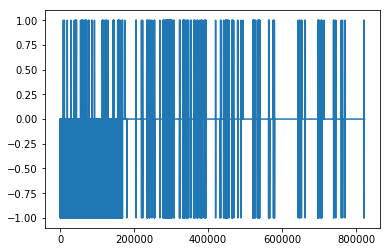

In [7]:
plt.plot(clicks)

In [8]:
# apply non-overlapping summation window to clicks
velocity_samp_rate_Hz = (1/np.diff(dfT, axis = 0)[0]) * 1e3; #secs

In [9]:
# derive cm/click
disk_radius = 6  #cm, distance from center of mouse to center of running disk
window_size = 1 #secs, size of window for velocities
window_step = 0.1 #secs, size of window step size velocities
encoder_CPR = 100 #cycles per revolution = 3.6 deg/cycle

In [10]:
deg_per_cycle = 360 / encoder_CPR #CPR specs of encoder
deg_per_click = deg_per_cycle / 4 #divide by 4 because using quadrature encoding
disk_circum = 2 * np.pi * disk_radius #cm
cm_per_deg = disk_circum/360
cm_per_click = cm_per_deg * deg_per_click

In [11]:
plt.plot(clicks_summed.to_numpy()) 

NameError: name 'clicks_summed' is not defined

In [12]:
dfC = pd.DataFrame(clicks)
rolling_window = (window_size * velocity_samp_rate_Hz)
rolling_window = rolling_window.astype(int)
clicks_summed = dfC.rolling(rolling_window[0]).sum()
clicks_summed = clicks_summed.to_numpy()
window_step_sec = window_step * velocity_samp_rate_Hz
window_step_sec = window_step_sec.astype(int)
clicks_summed = clicks_summed[np.arange(1,len(clicks_summed),window_step_sec)]

Text(0, 0.5, 'Speed (cm/sec)')

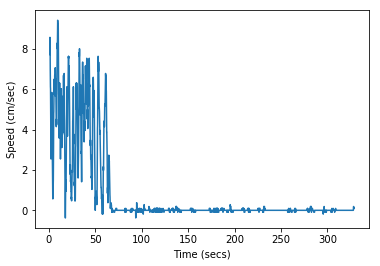

In [13]:

velocity_time_axis = dfT.Time_ms[np.arange(1,len(dfT),window_step_sec)]/1e3 #secs
velocity = -clicks_summed * cm_per_click #cm/sec, see derivation above.  Invert sign as of 2019-04-23

plt.plot(velocity_time_axis,velocity)
plt.xlabel('Time (secs)')
plt.ylabel('Speed (cm/sec)')
